In [103]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import median_survival_times
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 500

In [48]:
engine = create_engine("sqlite:///Data/shooting_slumps_data.db")

In [63]:
player_ids = pd.read_sql("ACTIVE_PLAYER_IDS", engine)
slump_data = pd.read_sql("SLUMP_DATA", engine)

In [64]:
slump_data["STATUS"] = [1]*len(slump_data)

In [65]:
print(slump_data.columns)

Index(['PLAYER_ID', 'NUM_GAMES', 'DECR_3PCT', '3PA', 'STATUS'], dtype='object')


<Axes: xlabel='timeline'>

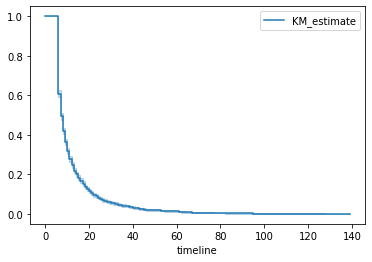

In [84]:
kmf = KaplanMeierFitter()
kmf.fit(durations = slump_data["NUM_GAMES"], event_observed = slump_data["STATUS"])
kmf.plot_survival_function()

In [97]:
num_games = np.arange(5, 80, .1)
surv_probs = kmf.survival_function_at_times(np.arange(5, 80, .1))
kmf_surv_function = pd.DataFrame({"NUM_GAMES": num_games, "SURV_PROB": surv_probs})
kmf_surv_function.to_sql("KMF_SURVIVAL_PROBABILITIES", engine, if_exists="replace", index=False)

750

In [99]:
kmf_surv_function.to_csv("Data/kmf_survival_probabilities.csv")

In [124]:
print(kmf.median_survival_time_)

7.0


In [125]:
print(median_survival_times(kmf.confidence_interval_))

     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                     7.0                     8.0


In [105]:
cph = CoxPHFitter()
cph.fit(slump_data, duration_col = 'NUM_GAMES', event_col = 'STATUS')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3480 total observations, 0 right-censored observations>
             duration col = 'NUM_GAMES'
                event col = 'STATUS'
      baseline estimation = breslow
   number of observations = 3480
number of events observed = 3480
   partial log-likelihood = -24621.59
         time fit was run = 2024-01-12 16:56:22 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
PLAYER_ID   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
DECR_3PCT  10.55   38035.73       0.35             9.87            11.23             19283.39             75023.99
3PA         0.08       1.09       0.01             0.07             0.10                 1.07                 1.10

            cmp to     z      p   -log2(p)
covariate                                 
PLAYER_ID     0.00  2.86 <0.005       7.87
DECR_3PCT     0.00 30.43 <0.005     673.20
3PA           0.00  9.71 <0.005      71.63
---
Concordance = 0.70
Partial AIC = 49249.19
log-likelihood ratio test = 564.13 on 3 df
-log2(p) of ll-ratio test = 402.68

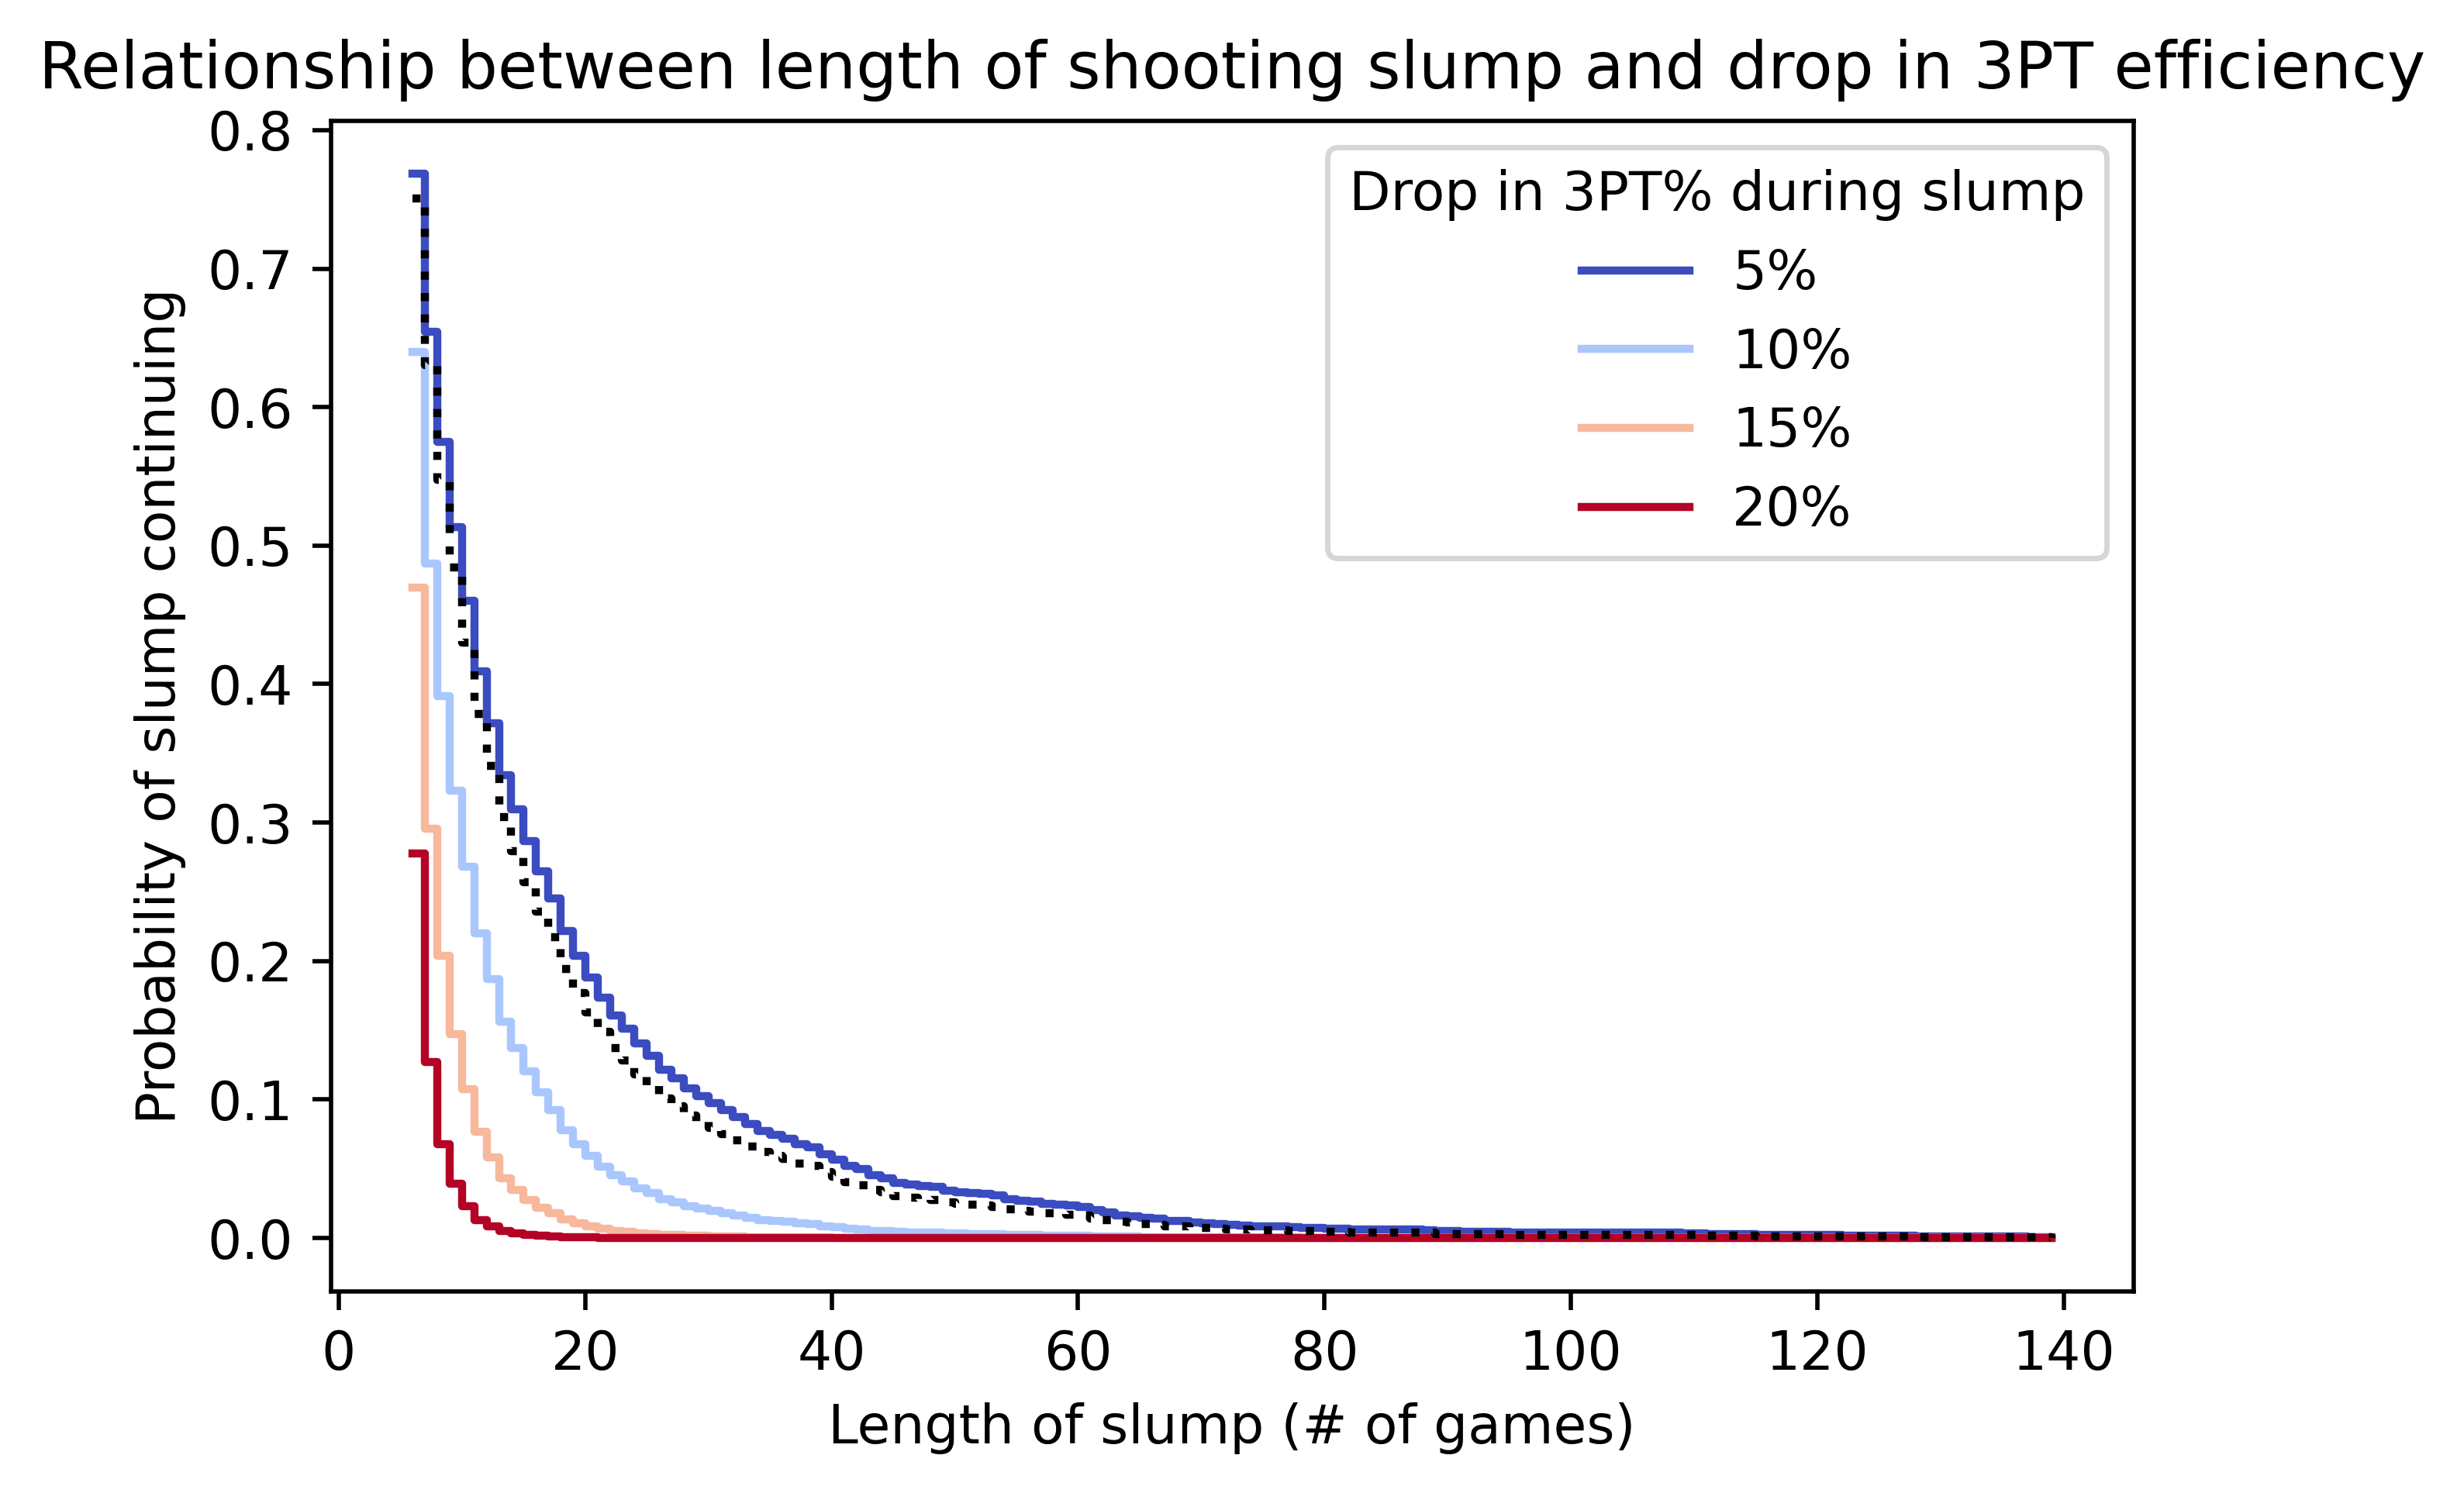

In [123]:
title="Relationship between length of shooting slump and drop in 3PT efficiency"
values = [.05, .1, .15, .2]
xlabel="Length of slump (# of games)"
ylabel="Probability of slump continuing"
plot = cph.plot_partial_effects_on_outcome(covariates = 'DECR_3PCT', values = values, cmap = 'coolwarm', title=title, xlabel=xlabel, ylabel=ylabel)
plt.legend(labels=["5%", "10%", "15%", "20%"], title="Drop in 3PT% during slump")

In [151]:
lines = plot.get_lines()  # Get the lines from the Axes object
data_points = [line.get_data() for line in lines]  # Extract data from each line

slump_length_plot_data = data_points[0][0]
bin_one_data = data_points[1][1]
bin_two_data = data_points[2][1]
bin_three_data = data_points[3][1]
bin_four_data = data_points[4][1]

out = {
    "slump_length": slump_length_plot_data,
    "five_pct": bin_one_data,
    "ten_pct": bin_two_data,
    "fifteen_pct": bin_three_data,
    "twenty_pct": bin_four_data
}
three_pct_slump_curves = pd.DataFrame(out)

three_pct_slump_curves.to_sql("THREE_PCT_SLUMP_CURVES", engine, if_exists="replace", index=False)
three_pct_slump_curves.to_csv("Data/three_pct_slump_curves.csv")

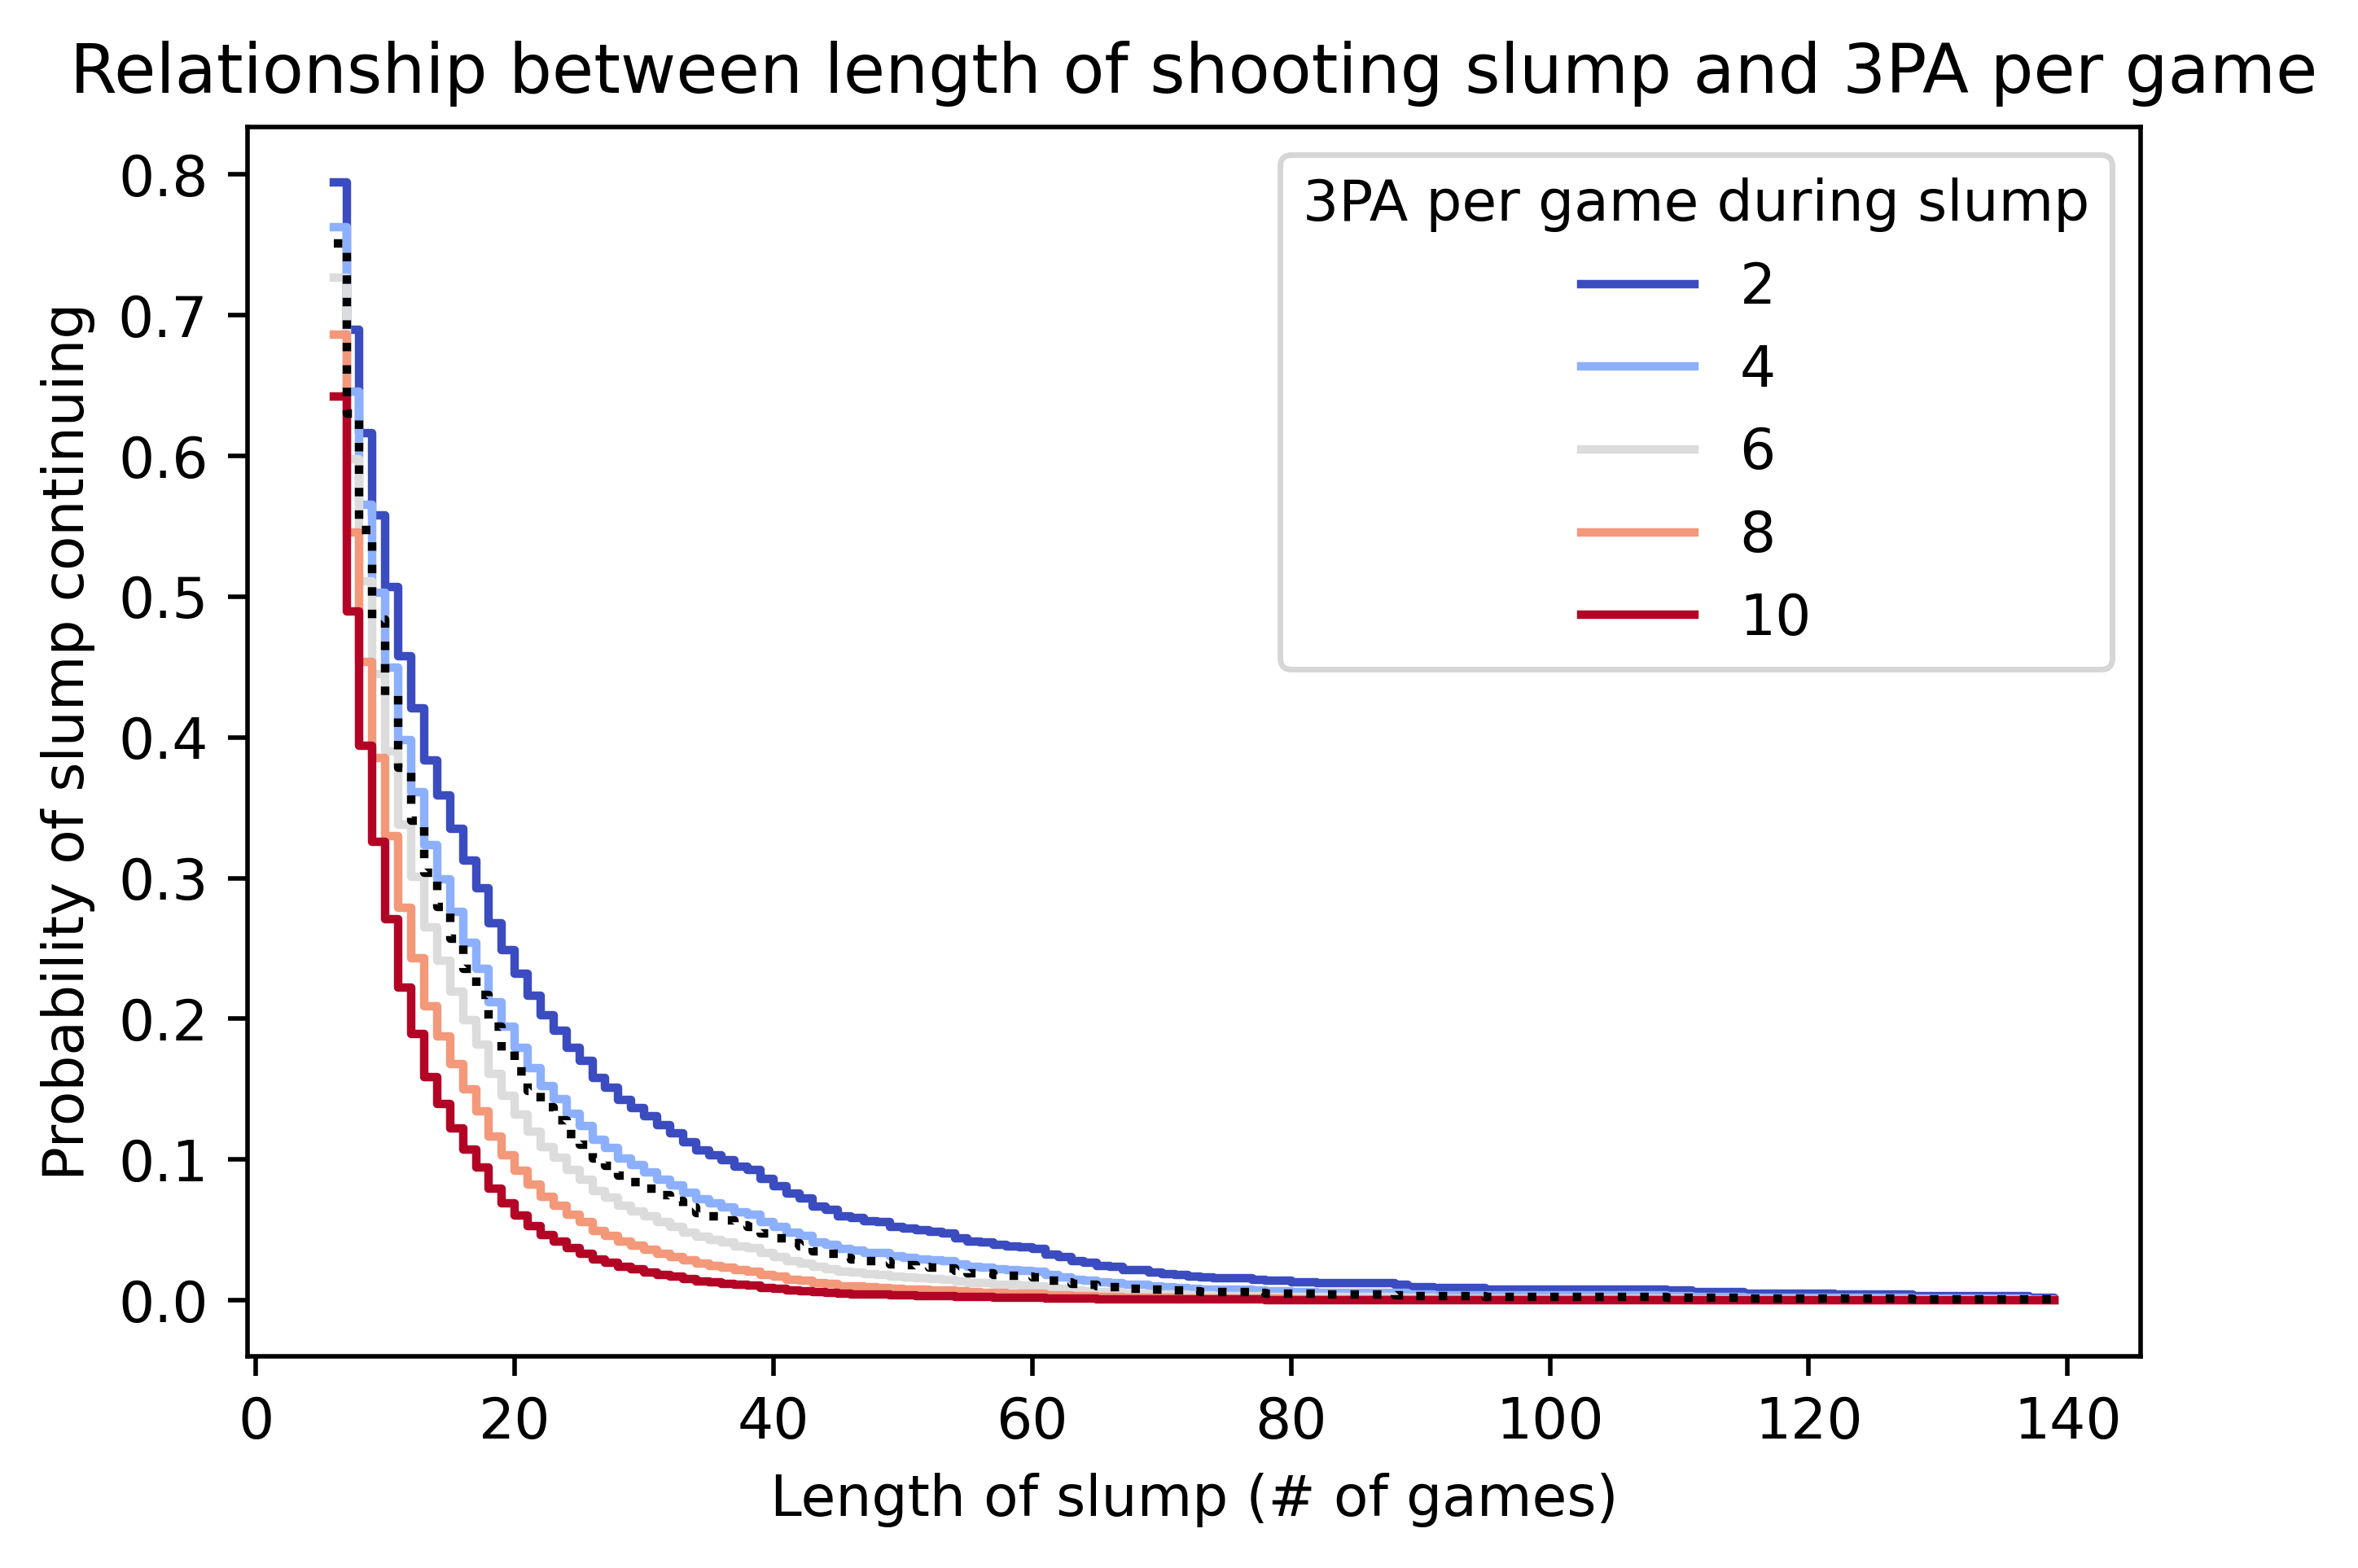

In [127]:
title="Relationship between length of shooting slump and 3PA per game"
values = [2, 4, 6, 8, 10]
xlabel="Length of slump (# of games)"
ylabel="Probability of slump continuing"
plot = cph.plot_partial_effects_on_outcome(covariates = '3PA', values = values, cmap = 'coolwarm', title=title, xlabel=xlabel, ylabel=ylabel)
plt.legend(labels=["2", "4", "6", "8", "10"], title="3PA per game during slump")

<Axes: >

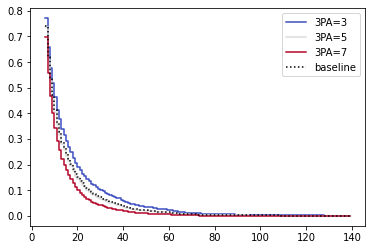

In [57]:
cph.plot_partial_effects_on_outcome(covariates = '3PA', values = [3, 5, 7], cmap = 'coolwarm')

<Axes: xlabel='timeline'>

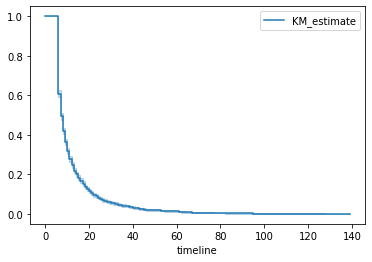

In [58]:
kmf = KaplanMeierFitter()
kmf.fit(durations = slump_data["NUM_GAMES"], event_observed = slump_data["STATUS"])
kmf.plot_survival_function()

<Axes: xlabel='timeline'>

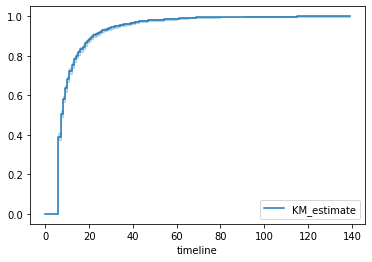

In [59]:
kmf.plot_cumulative_density()

In [60]:
print(kmf.median_survival_time_)

7.0
